Reads and parses fNIRS data with traditional ML techniques

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import os
import matplotlib.pyplot as plt

In [2]:
fnirs_path = os.path.join(os.getcwd(), "data/S902/2015-02-26_11-24-48-120", "fNIRSdata.txt")
marker_path = os.path.join(os.getcwd(), "data/S902/2015-02-26_11-24-48-120", "markers.txt")

First read the files

In [3]:
fnirs_df = pd.read_csv(fnirs_path, sep='\t', skiprows=range(4), index_col=False)

In [4]:
marker_df = pd.read_csv(marker_path, sep='\t', skiprows=range(4), index_col=False)

fnirs_df.Matlab_now.diff()

There seems to be cases where the experiment has ended but sensor are still running. So need to find that row and discard the following rows.

marker_df.iloc[3092]

In [5]:
marker_df_end_row = marker_df.loc[marker_df["Stimulus_Label"] == "experimentfinished"]
marker_df_end_time = marker_df_end_row["Matlab_now"].values[0]
fnirs_df_end_row = fnirs_df.loc[fnirs_df["Matlab_now"] == marker_df_end_time]

In [6]:
fnirs_df = fnirs_df[:fnirs_df_end_row.index[0]+1]
marker_df = marker_df[:marker_df_end_row.index[0]+1]

in marker_df, we can see that `Stimulus_String` column is just a combination of the columns `Trial_no`, `Stimulus_Label` and `Stimulus_Time`

In [7]:
merged_df = pd.merge(fnirs_df, marker_df, on="Matlab_now", how="left")

In [8]:
BASELINE_START = "baselinestart"
BASELINE_END = "baselineend"
EASY_START = "easystart"
EASY_END = "easyend"
HARD_START = "hardstart"
HARD_END = "hardend"

In [9]:
marker_df

,NbPoints,Matlab_now,BoxyTime,Stimulus_String,Trial_no,Stimulus_Label,Stimulus_Time
0,342,41117.786,5971.909,1;baselinestart;1424967917714;,1,baselinestart,1.424968e+12
1,1037,41176.770,6030.871,1;baselineend;1424967976760;,1,baselineend,1.424968e+12
2,1112,41183.101,6037.234,7;easystart;1424967983086;,7,easystart,1.424968e+12
3,1466,41213.115,6067.251,7;easyend;1424968013103;,7,easyend,1.424968e+12
4,1774,41239.258,6093.380,22;hardstart;1424968039235;,22,hardstart,1.424968e+12
5,2128,41269.257,6123.418,22;hardend;1424968069238;,22,hardend,1.424968e+12
6,2436,41295.370,6149.527,5;easystart;1424968095285;,5,easystart,1.424968e+12
7,2789,41325.289,6179.459,5;easyend;1424968125288;,5,easyend,1.424968e+12
8,3097,41351.417,6205.611,4;easystart;1424968151388;,4,easystart,1.424968e+12
9,3451,41381.447,6235.626,4;easyend;1424968181391;,4,easyend,1.424968e+12


In [10]:
fnirs_df

,Matlab_now,Increasing Marker,BoxyTime,Marker,A-DC1,A-DC2,A-DC3,A-DC4,A-DC5,A-DC6,A-DC7,A-DC8,B-DC1,B-DC2,B-DC3,B-DC4,B-DC5,B-DC6,B-DC7,B-DC8
0,41088.816,0,5943.069,0,1954.0,492.9,135.9,41.25,1846.0,452.4,112.5,29.92,287.2,79.62,24.38,7.141,385.5,117.5,37.50,13.12
1,41088.990,0,5943.153,0,1959.0,489.0,134.9,41.34,1847.0,453.0,112.9,29.88,285.5,79.85,24.46,7.150,384.8,117.5,37.39,13.11
2,41089.055,0,5943.237,0,1964.0,491.5,135.8,41.23,1846.0,455.3,113.4,29.91,286.0,79.82,24.55,7.153,385.1,117.4,37.29,13.09
3,41089.133,0,5943.321,0,1952.0,494.6,135.3,41.15,1846.0,453.5,113.6,29.97,286.5,79.79,24.56,7.136,385.0,117.2,37.51,13.15
4,41089.271,0,5943.447,0,1965.0,493.2,135.1,41.36,1850.0,453.2,113.1,29.94,286.6,79.57,24.58,7.157,386.2,117.1,37.57,13.16
5,41089.333,0,5943.531,0,1952.0,494.8,135.7,41.41,1839.0,454.1,113.5,30.01,286.3,79.77,24.64,7.159,386.0,118.3,37.78,13.21
6,41089.396,0,5943.615,0,1955.0,496.2,136.5,41.37,1842.0,455.3,113.9,30.04,288.3,79.84,24.56,7.188,386.7,117.7,37.63,13.27
7,41089.523,0,5943.678,0,1963.0,493.6,136.0,41.47,1837.0,455.8,113.5,30.18,290.0,80.06,24.58,7.191,387.9,118.6,37.91,13.28
8,41089.600,0,5943.763,0,1962.0,499.2,136.3,41.74,1848.0,457.8,113.5,30.03,285.8,80.15,24.76,7.208,388.9,117.8,38.00,13.28
9,41089.678,0,5943.847,0,1955.0,494.8,136.0,41.43,1837.0,455.6,113.7,29.92,287.9,79.96,24.66,7.202,387.0,117.9,37.69,13.16


In [11]:
merged_df

,Matlab_now,Increasing Marker,BoxyTime_x,Marker,A-DC1,A-DC2,A-DC3,A-DC4,A-DC5,A-DC6,...,B-DC5,B-DC6,B-DC7,B-DC8,NbPoints,BoxyTime_y,Stimulus_String,Trial_no,Stimulus_Label,Stimulus_Time
0,41088.816,0,5943.069,0,1954.0,492.9,135.9,41.25,1846.0,452.4,...,385.5,117.5,37.50,13.12,NaN,NaN,NaN,NaN,NaN,NaN
1,41088.990,0,5943.153,0,1959.0,489.0,134.9,41.34,1847.0,453.0,...,384.8,117.5,37.39,13.11,NaN,NaN,NaN,NaN,NaN,NaN
2,41089.055,0,5943.237,0,1964.0,491.5,135.8,41.23,1846.0,455.3,...,385.1,117.4,37.29,13.09,NaN,NaN,NaN,NaN,NaN,NaN
3,41089.133,0,5943.321,0,1952.0,494.6,135.3,41.15,1846.0,453.5,...,385.0,117.2,37.51,13.15,NaN,NaN,NaN,NaN,NaN,NaN
4,41089.271,0,5943.447,0,1965.0,493.2,135.1,41.36,1850.0,453.2,...,386.2,117.1,37.57,13.16,NaN,NaN,NaN,NaN,NaN,NaN
5,41089.333,0,5943.531,0,1952.0,494.8,135.7,41.41,1839.0,454.1,...,386.0,118.3,37.78,13.21,NaN,NaN,NaN,NaN,NaN,NaN
6,41089.396,0,5943.615,0,1955.0,496.2,136.5,41.37,1842.0,455.3,...,386.7,117.7,37.63,13.27,NaN,NaN,NaN,NaN,NaN,NaN
7,41089.523,0,5943.678,0,1963.0,493.6,136.0,41.47,1837.0,455.8,...,387.9,118.6,37.91,13.28,NaN,NaN,NaN,NaN,NaN,NaN
8,41089.600,0,5943.763,0,1962.0,499.2,136.3,41.74,1848.0,457.8,...,388.9,117.8,38.00,13.28,NaN,NaN,NaN,NaN,NaN,NaN
9,41089.678,0,5943.847,0,1955.0,494.8,136.0,41.43,1837.0,455.6,...,387.0,117.9,37.69,13.16,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
easy_start_rows = merged_df.index[merged_df.Stimulus_Label == EASY_START].tolist()
easy_end_rows = merged_df.index[merged_df.Stimulus_Label == EASY_END].tolist()
hard_start_rows = merged_df.index[merged_df.Stimulus_Label == HARD_START].tolist()
hard_end_rows = merged_df.index[merged_df.Stimulus_Label == HARD_END].tolist()

In [13]:
easy_rows = list(zip(easy_start_rows, easy_end_rows))
hard_rows = list(zip(hard_start_rows, hard_end_rows))

In [14]:
[x[1] - x[0] for x in easy_rows]

[354, 353, 354, 354, 354, 354, 354, 354, 354, 354, 354]

In [15]:
[y[1] - y[0] for y in hard_rows]

[354, 354, 354, 354, 354, 354, 354, 354, 354, 353, 354]

In [16]:
merged_df.iloc[easy_rows[0][0]: easy_rows[0][1]+1]

,Matlab_now,Increasing Marker,BoxyTime_x,Marker,A-DC1,A-DC2,A-DC3,A-DC4,A-DC5,A-DC6,...,B-DC5,B-DC6,B-DC7,B-DC8,NbPoints,BoxyTime_y,Stimulus_String,Trial_no,Stimulus_Label,Stimulus_Time
1111,41183.101,0,6037.297,0,1885.0,478.9,131.2,40.20,1800.0,441.0,...,378.8,114.7,36.36,12.69,1112.0,6037.234,7;easystart;1424967983086;,7,easystart,1.424968e+12
1112,41183.163,0,6037.381,0,1896.0,472.0,131.3,40.10,1805.0,440.4,...,379.3,114.9,36.57,12.72,NaN,NaN,NaN,NaN,NaN,NaN
1113,41183.227,0,6037.465,0,1882.0,478.3,131.8,40.22,1804.0,441.7,...,379.2,114.9,36.41,12.75,NaN,NaN,NaN,NaN,NaN,NaN
1114,41183.365,0,6037.591,0,1885.0,474.8,131.1,40.17,1802.0,442.2,...,376.4,114.2,36.34,12.63,NaN,NaN,NaN,NaN,NaN,NaN
1115,41183.430,0,6037.675,0,1886.0,476.7,130.4,39.66,1804.0,440.2,...,376.6,114.0,36.10,12.65,NaN,NaN,NaN,NaN,NaN,NaN
1116,41183.568,0,6037.759,0,1883.0,473.3,130.6,39.77,1809.0,440.9,...,377.2,114.0,36.19,12.61,NaN,NaN,NaN,NaN,NaN,NaN
1117,41183.634,0,6037.843,0,1883.0,479.3,130.4,40.07,1806.0,441.3,...,376.5,114.4,36.26,12.61,NaN,NaN,NaN,NaN,NaN,NaN
1118,41183.709,0,6037.906,0,1877.0,475.9,130.0,40.21,1797.0,443.5,...,376.9,114.0,36.28,12.63,NaN,NaN,NaN,NaN,NaN,NaN
1119,41183.771,0,6037.990,0,1880.0,474.1,130.7,40.00,1805.0,442.0,...,377.8,114.3,36.52,12.69,NaN,NaN,NaN,NaN,NaN,NaN
1120,41183.833,0,6038.074,0,1901.0,475.7,130.8,40.19,1803.0,443.0,...,378.7,114.7,36.44,12.67,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
x = range(easy_rows[0][1] - easy_rows[0][0] + 1)
y = merged_df.iloc[easy_rows[0][0]: easy_rows[0][1]+1]["A-DC1"].values.tolist()

In [18]:
y

[1885.0,
 1896.0,
 1882.0,
 1885.0,
 1886.0,
 1883.0,
 1883.0,
 1877.0,
 1880.0,
 1901.0,
 1897.0,
 1890.0,
 1879.0,
 1884.0,
 1880.0,
 1885.0,
 1882.0,
 1884.0,
 1887.0,
 1886.0,
 1888.0,
 1890.0,
 1891.0,
 1875.0,
 1876.0,
 1872.0,
 1877.0,
 1874.0,
 1887.0,
 1887.0,
 1878.0,
 1875.0,
 1878.0,
 1876.0,
 1879.0,
 1884.0,
 1875.0,
 1888.0,
 1886.0,
 1887.0,
 1891.0,
 1901.0,
 1899.0,
 1884.0,
 1878.0,
 1883.0,
 1877.0,
 1885.0,
 1881.0,
 1888.0,
 1885.0,
 1891.0,
 1891.0,
 1880.0,
 1883.0,
 1885.0,
 1876.0,
 1883.0,
 1886.0,
 1891.0,
 1883.0,
 1893.0,
 1885.0,
 1884.0,
 1872.0,
 1867.0,
 1885.0,
 1882.0,
 1889.0,
 1892.0,
 1896.0,
 1897.0,
 1886.0,
 1882.0,
 1878.0,
 1876.0,
 1874.0,
 1875.0,
 1864.0,
 1885.0,
 1865.0,
 1882.0,
 1886.0,
 1877.0,
 1864.0,
 1863.0,
 1861.0,
 1862.0,
 1861.0,
 1862.0,
 1865.0,
 1856.0,
 1845.0,
 1855.0,
 1847.0,
 1837.0,
 1842.0,
 1839.0,
 1844.0,
 1842.0,
 1855.0,
 1850.0,
 1864.0,
 1860.0,
 1859.0,
 1863.0,
 1854.0,
 1853.0,
 1845.0,
 1860.0,
 1849.0,
 

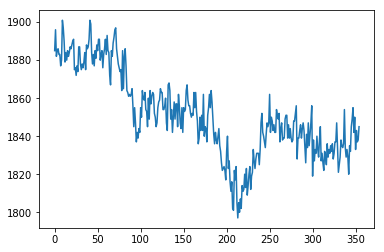

In [19]:
plt.plot(x,y)